# Histogram Equilization and Histogram Specification
In this assignment we will learn about histograms, some of their applications and techinques used to play with them 

### Utils
To initialise the assignment, run these 3 cells only once

In [1]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1gCiAZnEiEzOsrfU97Z7lk0pjDhiBnfF0'
destination = '/content/dataset.zip'
download_file_from_google_drive(file_id, destination)

In [2]:
!unzip -q dataset.zip
!rm -rf dataset.zip

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import *
def load_image(number):
  img = cv2.imread(f"/content/original_images/img{number}.bmp")
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return gray

def show_image(image):
  plt.figure(figsize=(12,5))
  plt.imshow(image,cmap='gray')
  plt.axis('off')
  plt.show()

def calculate_hist(gray):
  fig,ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].imshow(gray,cmap="gray")
  ax[0].axis('off')
  ax[0].set_title("Image")

  ax[1].hist(gray.ravel(), bins=32, range=(0.0, 256.0), ec='k') #calculating histogram
  ax[1].set_title("Histogram")
  ax[1].set_xlabel("range")
  plt.show()

def compare_matched_hist(src,dst,matched_src):
  images = [src,dst,matched_src]
  headings = ["Source","Destination","Matched Source"]
  n,m = len(images),2
  fig,ax = plt.subplots(n,m,figsize=(15,10))

  for i, (heading,img) in enumerate(zip(headings,images)):
    ax[i,0].imshow(img,cmap="gray")
    ax[i,0].axis('off')
    ax[i,0].set_title(heading)

    ax[i,1].hist(img.ravel(), bins=32, range=(0.0, 256.0), ec='k') #calculating histogram
  plt.show()

### Question 1: What are Histograms?
[1 mark]

A histogram is an approximate representation of the distribution of some numerical data. It is the most commonly used graph to show frequency distributions. It looks very much like a bar chart. 

In terms of image: 
Histogram is a graphical representation of the intensity distribution of an image. In simple terms, it represents the number of pixels for each intensity value considered.

### Questions 2: Applications of Histograms?
[1]


Histograms are preferred in applications, when their is a need for any of the following: 

-  The data are numerical and the distribution of data is needed to be observed, especially when determining whether the output of a process is distributed approximately normally or not

- Seeing whether a process change has occurred from one time period to another

- Determining whether the outputs of two or more processes are different

- Statistical properties need to be modeled

Some specific use cases of histograms are

- In hydrology the histogram and estimated density function of rainfall are used to gain insight in their behaviour and frequency of occurrence. 

- In many Digital Image processing programs there is a histogram tool, which show you the distribution of the contrast / brightness of the pixels. 

## Histogram Equalizing


### Question 3: What is Histogram Equalizaiton 
[1]

Histogram equalization is a method for contrast adjustment using the image's histogram.
Basically, it is a computer image processing technique used to improve contrast in images. It accomplishes this by effectively spreading out the most frequent intensity values. When the useable data is represented by near contrast values, this approach generally boosts the global contrast of pictures. This enables locations with poor local contrast to gain a higher contrast.


### Question 4 
below are some inbuilt examples of histogram equalizing from OpenCV, your task is to reproduce them without using any inbuilts, you can use the function `calculate_hist` to show insights, also **explain your results comparing** with inbuilt. [1+1]

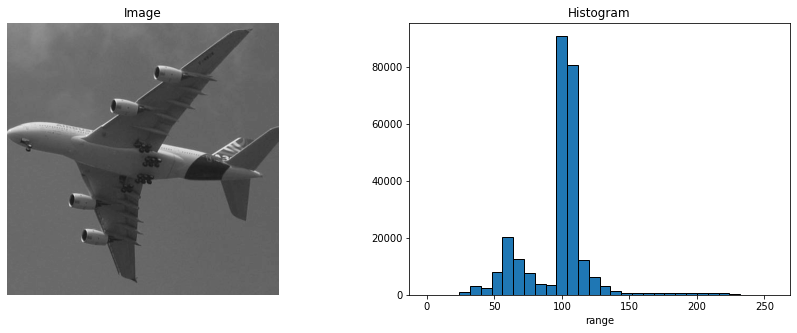

In [4]:
gray = load_image(3)
calculate_hist(gray)

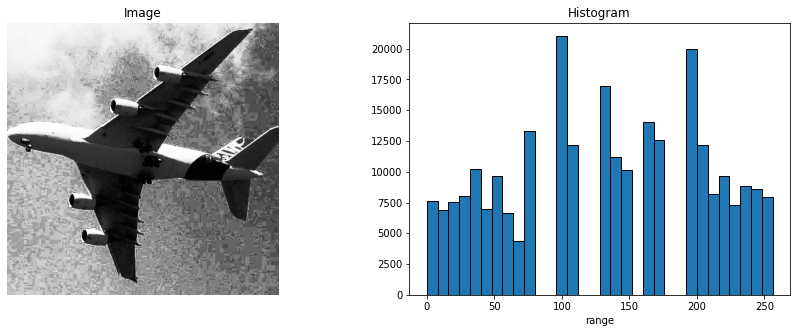

In [5]:
equalized_gray = cv2.equalizeHist(gray)
calculate_hist(equalized_gray)

In [6]:
number_of_bins = 256
def cumulative_distribution(image):
    """
    :param src: input image
    :rtype: image 
    :return img_cdf: Normalized Cumulative distribtion of the input image
    """

    img_hist = np.zeros(number_of_bins)

    # Find the histogram 
    for pixel in image:
        img_hist[pixel] += 1
    
    # Calculate the culumative distribution of the image
    img_cdf = img_hist.cumsum()
    # Normalize the image
    img_cdf = ((img_cdf - img_cdf.min())*255) / (img_cdf.max() - img_cdf.min())
    img_cdf = img_cdf.astype(int)
    return img_cdf

def my_equalizing_histograms(src):
    """
    :param src: input image
    :rtype: image 
    :return dest: histogram equalized src image
    """
    dest = None
    img = src.copy()
    # Convert source image to 1D flat array
    img = np.asarray(img).flatten()
    # Finding CDF
    cdf = cumulative_distribution(img)
    # final image
    dest = cdf[img]
    # Reshaping and de-normalizing the image
    return dest.reshape(src.shape)

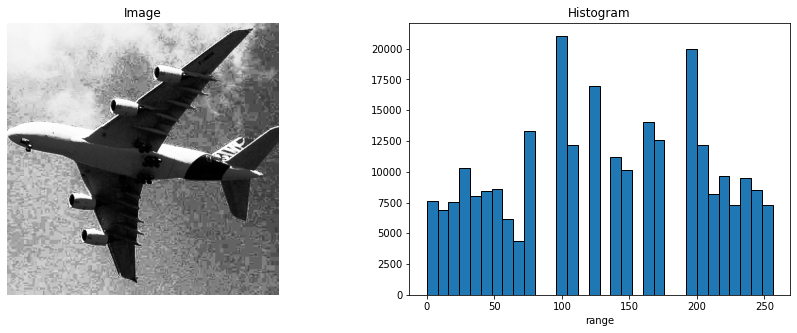

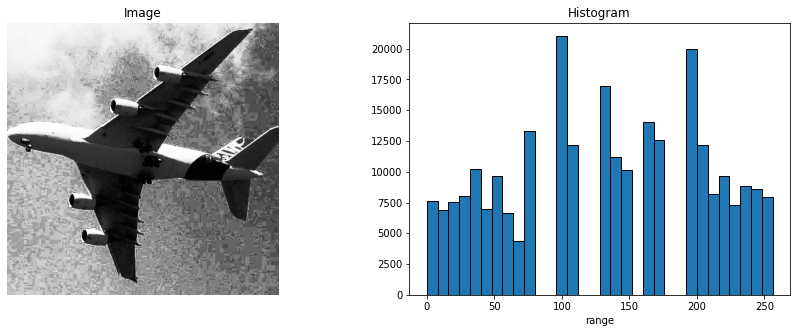

In [7]:
my_equalized_gray = my_equalizing_histograms(gray)
calculate_hist(my_equalized_gray)
calculate_hist(equalized_gray)

Comparing with the inbulit results, my custom implementation seems to be reproducing almost similar results.
The image histogram of the inbuilt function and the custom implementation are almost similar. Apart from the
histogram, the contrast of the image itself has been improved, and the implementation seems to be performing histogram equalization correctly.

## Histogram Matching

### Question 5: What is Histogram Matching
[1]

Histogram matching is the transformation of an image so that its histogram matches a specified histogram. 
In order to match the histogram of images A and B, we need to first equalize the histogram of both images. Then, we need to map each pixel of A to B using the equalized histograms. Then we modify each pixel of A based on that of B.

Histogram matching may be used to balance detector responses. It can be used to equalise two pictures that were taken in the same place with the same local lighting (such as shadows), but with different sensors, atmospheric conditions, or global illumination.

### Question 6
below are some inbuilt examples of histogram matching from scikit image, your task is to reproduce them without using any inbuilts, you can use the function `compare_matched_hist` to show insights, also **explain your results comparing** with inbuilt.
[2+1]

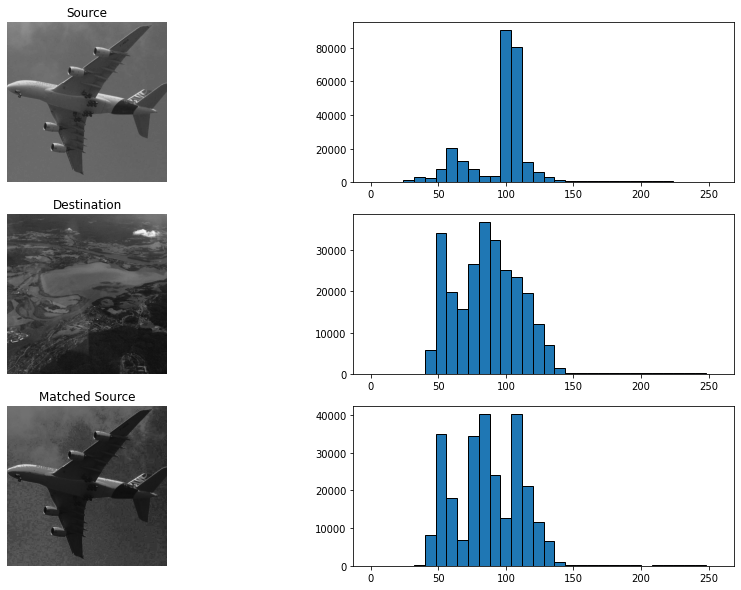

In [8]:
from skimage import exposure

src = load_image(3)
dst = load_image(4)
matched_src = exposure.match_histograms(src,dst)

compare_matched_hist(src,dst,matched_src)

In [9]:
def my_matching_histograms(src,dst):
    """
    :param src: input image
    :param dst: reference image
    :rtype: image 
    :return mathced_src: histogram matched src image
    """
    src_values, src_unique_indices, src_counts = np.unique(src.ravel(), return_counts=True, return_inverse=True)
    dst_values, dst_counts = np.unique(dst.ravel(), return_counts=True)

    # Normalizing cdf for source and destination images
    src_cdf = np.cumsum(src_counts) / len(src)
    dst_cdf = np.cumsum(dst_counts) / len(dst)

    matched_src = np.interp(src_cdf, dst_cdf, dst_values)
    return matched_src[src_unique_indices].reshape(src.shape)

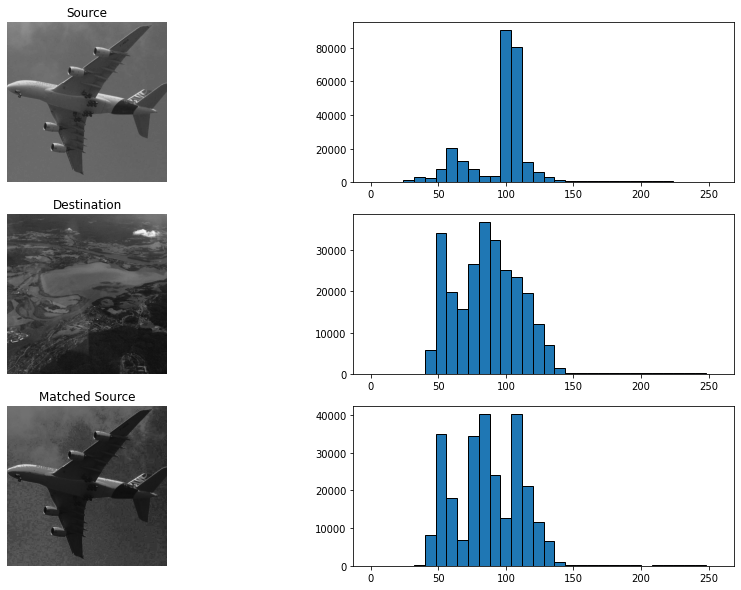

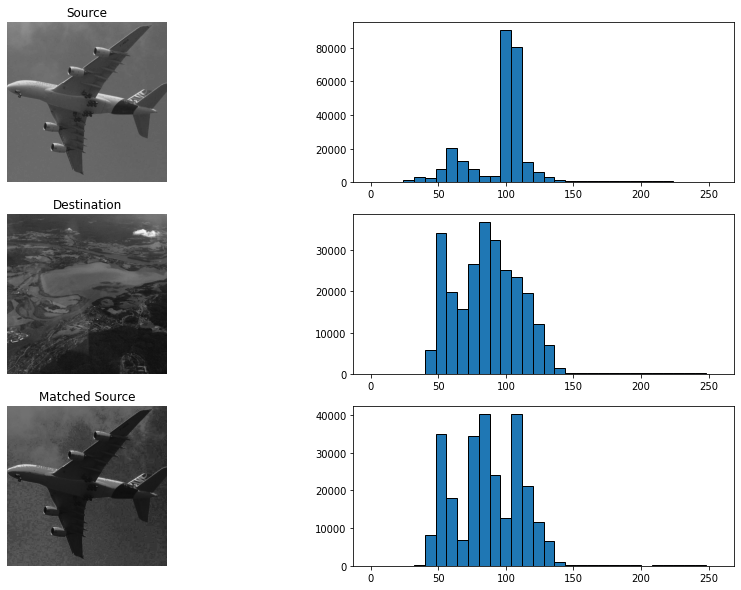

In [10]:
my_matched_src = my_matching_histograms(src,dst)
compare_matched_hist(src,dst,my_matched_src)
compare_matched_hist(src,dst,matched_src)

Comparing with the inbuilt results, both the image and the histogram appear to be almost similar. The purpose of histogram matching also seems to have been achieved as far as it can be. Since the source and the destination images are completely different one, therefore tha matching is not perfect. However the overall lighting and contrast seems to have been matched to the destination image. 

### Question 7
Checking optimization
[1]

In [11]:
src = load_image(1)
dst = load_image(2)

In [12]:
%%timeit

my_equalizing_histograms(src)
my_matching_histograms(src,dst)

1 loop, best of 5: 203 ms per loop


Reference 
- https://en.wikipedia.org/wiki/Histogram_equalization
- https://en.wikipedia.org/wiki/Cumulative_distribution_function
- https://en.wikipedia.org/wiki/Histogram_matching
- http://paulbourke.net/miscellaneous/equalisation/
